# Сборный проект

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
В датасете данные до 2016 года, необходимо спланировать компанию на 2017-й. 

## Импорт библиотек

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Изучение данных из файла

In [2]:
data = pd.read_csv('/Users/daniilsobolev/Desktop/ml projects/Сборный проект/games.csv')

In [3]:
data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1768,Doraemon,NES,1986.0,Action,0.00,0.00,1.15,0.00,NaN,NaN,NaN
4747,Rocksmith 2014,XOne,2014.0,Misc,0.29,0.08,0.00,0.04,NaN,NaN,NaN
11583,Resident Evil 6,PS4,2016.0,Shooter,0.06,0.00,0.00,0.01,60.0,6.7,M
6663,Samurai Shodown II,NG,1994.0,Fighting,0.00,0.00,0.25,0.00,NaN,NaN,NaN
12369,The Pinball of the Dead,GBA,2002.0,Misc,0.05,0.02,0.00,0.00,79.0,tbd,T


### Описание

**Name** — название игры <br>
**Platform** — платформа <br>
**Year_of_Release** — год выпуска <br>
**Genre** — жанр игры <br>
**NA_sales** — продажи в Северной Америке (миллионы проданных копий) <br>
**EU_sales** — продажи в Европе (миллионы проданных копий) <br>
**JP_sales** — продажи в Японии (миллионы проданных копий) <br>
**Other_sales** — продажи в других странах (миллионы проданных копий) <br>
**Critic_Score** — оценка критиков (максимум 100) <br>
**User_Score** — оценка пользователей (максимум 10) <br>
**Rating** — рейтинг от организации ESRB  <br>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.isna().mean().sort_values()*100

Platform            0.000000
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
Name                0.011965
Genre               0.011965
Year_of_Release     1.609333
User_Score         40.089740
Rating             40.478612
Critic_Score       51.319174
dtype: float64

### Вывод

**Сразу видно, что необходима дработка таблицы:**  <br>

1) Приведем названия столбцов в нижний регистр <br>
2) В столбцах Year_of_Release и Critic_Score изменим тип данных на int <br>
3) Изучим пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating <br>
4) А также посчитаем суммарные продажи во всех регионах и запишем их в новый столбец <br>
5) В столбце User_Score изменим тип данных на float

Приступим к предобработке

## Предобработка данных 

In [6]:
data.columns = data.columns.str.lower()

Пропуски в столбцах **name, year_of_release, genre** составляют менее 2% данных, поэтому просто удалим их.<br>

In [7]:
data.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

Пропуски в столбцах **critic_score, user_score, rating** заполним значением 101, в будущем имея в виду, что это пропуск.

In [8]:
data['critic_score'] = data['critic_score'].fillna(101)
data['user_score'] = data['user_score'].fillna(101)
data['rating'] = data['rating'].fillna(101)

В столбце **user_score** встречается некорректное значение 'tbd', что скорее всего значит - оценка ещё не определена, будет определена позже. Примем это значение как пропуск, заполним значением 101.

In [9]:
data[data['user_score'] == 'tbd'] = 101

Тип данных в столбцах **year_of_release** и **critic_score** заменим на int, так как там фигурируют целые значения. <br>
Тип данных в столбце **user_score** заменим на float, так как там дробные значения.

In [10]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['critic_score'] = data['critic_score'].astype('int')
data['user_score'] = data['user_score'].astype('float')

In [11]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [12]:
data.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
835,Need for Speed: ProStreet,PS3,2007,Racing,0.73,0.91,0.04,0.36,73,6.0,E10+,2.04
9191,Frank Thomas Big Hurt Baseball,PS,1996,Sports,0.08,0.05,0.00,0.01,101,101.0,101,0.14
7418,Prince of Persia: Revelations,PSP,2005,Adventure,0.18,0.01,0.00,0.02,101,101.0,101,0.21


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  sales            16444 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


### Вывод

Мы встретили большое количество пропусков в столбцах **rating** и **critic_score**. <br>

Пропуски в столбце **rating** могли быть связаны с тем, что игра вышла недавно, определение рейтинга - это не самый быстрый процесс, причем игра на старте может дорабатываться, то есть её рейтинг может меняться, а также компания может опсаривать решение комисии. Также, скорее всего, существуют игры без рейтинга. <br>

Пропуски в столбце **critic_score** также связаны с тем, что игра вышла недавно, критики не успели сформировать свою точку зрения.

Также эти пропуски могли быть связаны с непопулярностью игры или с тем временем, когда рейтинг и оценка кртиков не выставлялись.

Данные были доработаны, перейдем к анализу.

## Исследовательский анализ данных

**Посмотрим и проанализируем следующее:**

1) Сколько игр выпускалось в разные года <br>
2) Изменение продаж по платформам <br>
3) Определим актуальный период данных. То есть те данные, которые помогут построить прогноз на 2017 год <br>
4) Посмотрим, какие платформы лидируют по продажам, растут, падают. Выберем несколько потенциально прибыльных платформ <br>
5) Посмотрим на график «ящик с усами» по глобальным продажам игр в разбивке по платформам <br>
6) Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Соотнесём выводы с продажами игр на других платформах <br>
7) Посмотрим на общее распределение игр по жанрам <br>

### Анализ выпущенных игр по годам

In [14]:
data_year = pd.pivot_table(data, 
                        index=['year_of_release'], 
                        values='name', 
                        aggfunc=['count'])
data_year = data_year.reset_index()
data_year = data_year[data_year['year_of_release'] != 0]

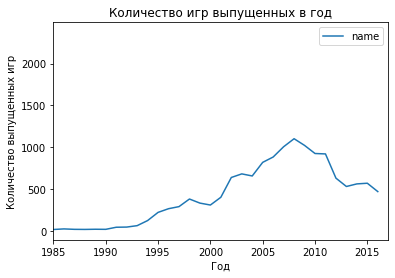

In [15]:
ax = data_year.plot(x='year_of_release', y='count')
ax.set_xlabel("Год")
ax.set_ylabel("Количество выпущенных игр")
ax.set_title('Количество игр выпущенных в год')
plt.xlim([1985, 2017])
plt.show()

#### Вывод

Из графика видно, что количество выпущенных игр возрастало до 2008-2009 годов, а далее их количество стало убывать.<br>

Это может быть свзяано с кризисом 2008 года, многие компании ушли с рынка, тем самым повлияв на количество выпущенных игр. <br>
А также в 2008 и далее годах технологии шагнули вперед и разработчики научились делать более сложные, более интересные, более долгие по прохождению игры.

### Анализ изменения продаж по платформам

In [16]:
data_platform = pd.pivot_table(data, 
                        index=['platform'], 
                        values='sales', 
                        aggfunc=['sum'])
data_platform = data_platform.reset_index()
data_platform = data_platform.sort_values(('sum', 'sales'), ignore_index=True)

In [17]:
display(data_platform.tail())

,platform,sum
,,sales
27,Wii,791.91
28,PS3,921.09
29,X360,948.74
30,PS2,1171.19
31,101,959904.00


In [18]:
def plot(name):
    data_x = data[data['platform'] == name]

    data_platform_x = pd.pivot_table(data_x, 
                            index=['year_of_release'], 
                            values='sales', 
                            aggfunc=['sum'])
    data_platform_x = data_platform_x.reset_index()

    ax = data_platform_x.plot(x='year_of_release', y='sum')
    ax.set_xlabel("Год")
    ax.set_ylabel("Суммарные продажи")
    ax.set_title(name)
    plt.show()

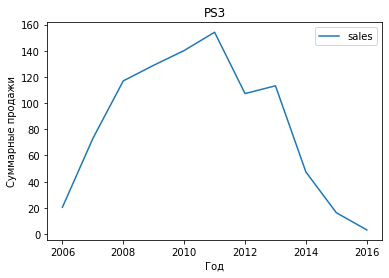

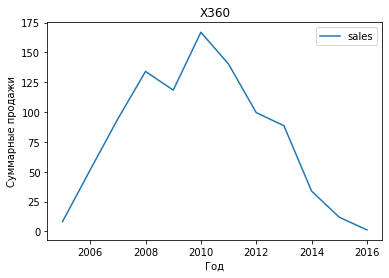

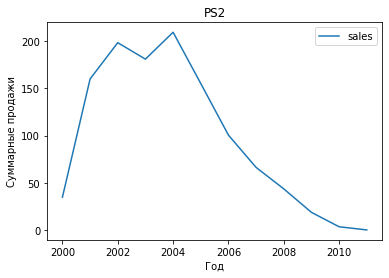

In [19]:
plot('PS3')
plot('X360')
plot('PS2')

#### Вывод

Для начала мы выявили пять платформ с наибольшими суммарными продажами, - это PS3, X360, PS2.<br>

Далее рассмотрели как были распределены суммарные продажи по годам. Из графиков видно, что период существования каждой из платформ в районе 10 лет.<br>

Всего в данных 31 платформа, если мы предположим, что половина из них закрылась и учитывая, что период существования каждой в райне 10 лет, то характерный срок за который повяляются новые и исчезают старые будет примерно равен: 2016-1985 / (31+15) * 12 = 8 месяцев.
То есть в течении 8 месяцев появляется новая или же исчезает старая платформа.<br>

Также из графиков видно, что приближаясь к 5 годам (половине срока существования) со дня появления платформы, суммарные продажи начинали снижаться. Скорее всего это связано с появлением более новых и лучших платформ.

Анализирая графики, можно заметить, что падение суммарных продаж самый больших платформ по продажам, приходится в среднем на 2008-2009 года, что коррелирует с пиком количества выпущенных игр за год. 

Нам необходимо выявить **актуальный период** для того, чтобы построить прогноз на 2017 год. 
Для этого все данные брать не нужно, возьмем данные за последние 3 года (2014-2016г).

In [20]:
data = data[data['year_of_release'] >= 2014]

### Анализ потенциально прибыльных платформ

In [21]:
data_platform = pd.pivot_table(data, 
                        index=['platform'], 
                        values='sales', 
                        aggfunc=['sum'])
data_platform = data_platform.reset_index()
data_platform = data_platform.sort_values(('sum', 'sales'), ignore_index=True)

In [22]:
display(data_platform.tail())

,platform,sum
,,sales
5,X360,46.86
6,PS3,66.86
7,3DS,85.38
8,XOne,139.81
9,PS4,288.01


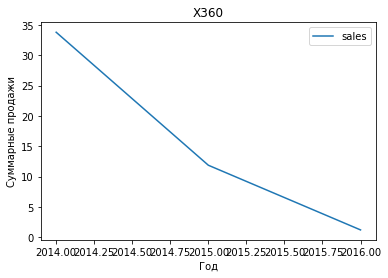

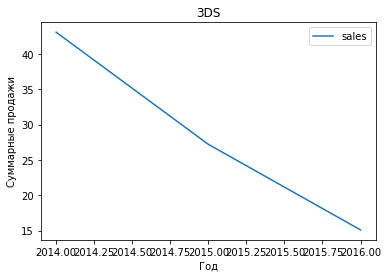

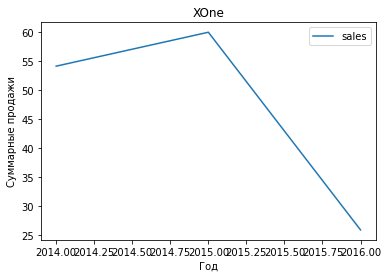

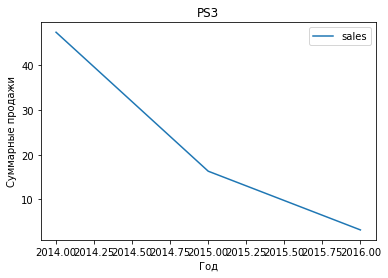

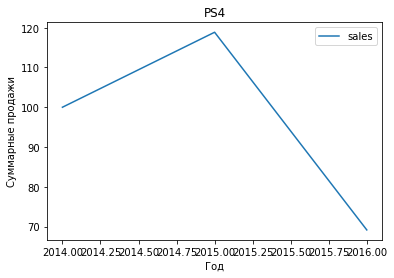

In [23]:
plot('X360')
plot('3DS')
plot('XOne')
plot('PS3')
plot('PS4')

#### Вывод

По продажам лидирует такие платформы, как: PS4, PS3, XOne, 3DS, X360.<br>
При этом у всех платформ упали продажи за 2016 год относительно 2015.<br>
Но у платформ PS4 и XOne наблюдается пик в 2015.<br>

Потенциально прибыльные платформы будут одни из: PS4, PS3, XOne, 3DS, X360. Но из графиков можно сделать вывод, что такие платформы, как PS3 и X360 стали мало актуальны и их продажи будут ближе к нулю, чем другие.<br>
Поэтому потенциально прибыльные платформы - это PS4, XOne, 3DS

### Ящик с усами

<AxesSubplot:xlabel='sales', ylabel='platform'>

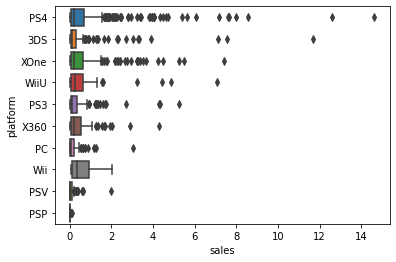

In [24]:
platform = data['platform']
sales = data['sales']

sns.boxplot(x=sales, y=platform)

(0.0, 1.0)

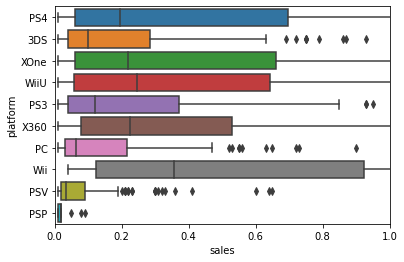

In [25]:
sns.boxplot(x=sales, y=platform).set_xlim([0, 1])  

#### Вывод

Продажи распределены неравномерно, есть множество выбросов значений. 

Также видно, что данные не симметричны, смещены влево(верхний квартиль много дальше по отношению к медиане, чем нижний), то есть существует очень много продаж со значением близким к нулю.

Также по диаграмме можно рассмотреть медиану, нижний и верхний квартили для каждой платформы. В нашем случае много выбросов, поэтому вывод из этого не сделаешь.

### Распределение игр по жанрам

In [26]:
data_genre = pd.pivot_table(data, 
                        index=['genre'], 
                        values='sales', 
                        aggfunc=['median', 'mean'])
data_genre = data_genre.reset_index()

In [27]:
data_genre = data_genre.sort_values(('mean', 'sales'), ignore_index=True)
display(data_genre.tail())

,genre,median,mean
,,sales,sales
7,Role-Playing,0.110,0.459005
8,Fighting,0.130,0.485172
9,Platform,0.145,0.519412
10,Sports,0.240,0.722450
11,Shooter,0.560,1.387967


#### Вывод

Самые прибыльные жанры - это Shooter, Sports и Platform. Данные жанры наиболее сильно выделяются на фоне остальных по средним продажам. Причем, жанр Shooter прибыльней остальных в 2 и болле раз.

### Влияние отзывов пользователей и критиков

#### Сперва посмотрим, как влияют отзывы критиков среди одной популярной платформы:

In [28]:
data_PS4 = data[data['platform'] == 'PS4']
data_PS4 = data_PS4[data_PS4['critic_score'] != 101]
data_PS4 = data_PS4[data_PS4['user_score'] != 101]

In [29]:
data_PS4['critic_score'].corr(data_PS4['sales'])

0.40190287811475334

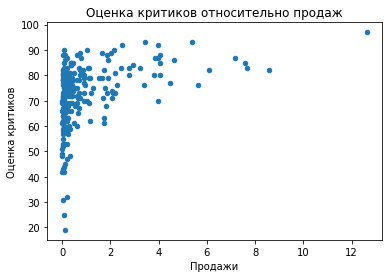

In [30]:
ax = data_PS4.plot.scatter(x='sales', y='critic_score', marker='o')
ax.set_xlabel("Продажи")
ax.set_ylabel("Оценка критиков")
ax.set_title('Оценка критиков относительно продаж')
plt.show()

#### Посмотрим, как влияют отзывы пользователей, среди одной популярной платформы:

In [31]:
data_PS4['user_score'].corr(data_PS4['sales'])

-0.04318585997193634

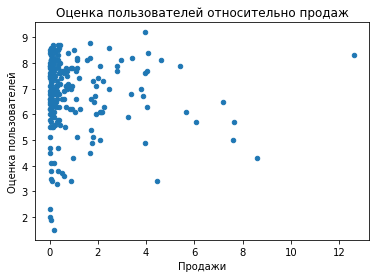

In [32]:
ax = data_PS4.plot.scatter(x='sales', y='user_score')
ax.set_xlabel("Продажи")
ax.set_ylabel("Оценка пользователей")
ax.set_title('Оценка пользователей относительно продаж')
plt.show()

#### Посмотрим на те же взаимосвязи в случае всех платформ

In [33]:
data_all = data[data['critic_score'] != 101]
data_all = data_all[data_all['user_score'] != 101]

data['critic_score'].corr(data['sales'])

-0.009760253058558334

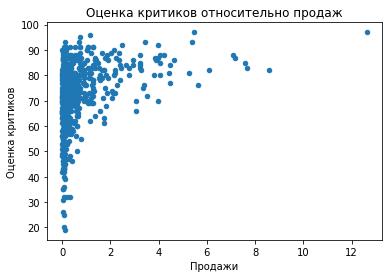

In [34]:
ax = data_all.plot.scatter(x='sales', y='critic_score', marker='o')
ax.set_xlabel("Продажи")
ax.set_ylabel("Оценка критиков")
ax.set_title('Оценка критиков относительно продаж')
plt.show()

In [35]:
data['user_score'].corr(data['sales'])

-0.14309047108111925

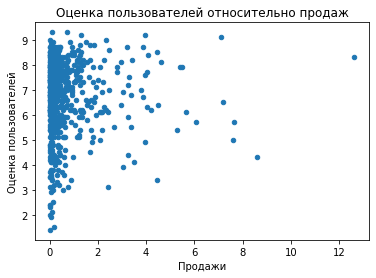

In [36]:
ax = data_all.plot.scatter(x='sales', y='user_score')
ax.set_xlabel("Продажи")
ax.set_ylabel("Оценка пользователей")
ax.set_title('Оценка пользователей относительно продаж')
plt.show()

#### Вывод

Из значения корреляции и графиков модем сделать вывод о том, что оценка пользователей и критиков не влияет на продажи.

Но также видно, что не бывает такого, что оценка критиков маленькая, а продажи большие. 

## Портрет пользователя каждого региона

### Самые популярные платформы

In [37]:
data_grouped = data.groupby(['platform']).sum()

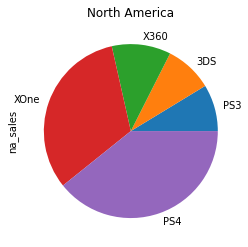

In [38]:
data_grouped = data_grouped.sort_values('na_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='na_sales', x='platform', legend=False)
ax.set_title('North America')
plt.show()

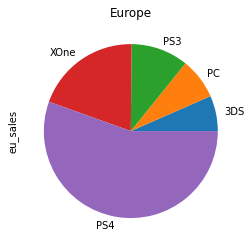

In [39]:
data_grouped = data_grouped.sort_values('eu_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='eu_sales', x='platform', legend=False)
ax.set_title('Europe')
plt.show()

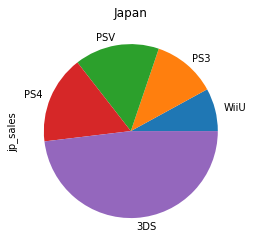

In [40]:
data_grouped = data_grouped.sort_values('jp_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='jp_sales', x='platform', legend=False)
ax.set_title('Japan')
plt.show()

#### Вывод

В Северной Америке самые популярные платформы: PS4, XOne, X360, PS4 и XOne составляют по одной трети от всех продаж популярных платформ.

В Европе самые популярные платформы: PS4, XOne, PS3, PS4 составляет больше половины от всех продаж популярных платформ.

В Японии самые популярные платформы: 3DS, PS4, PSv, 3DS составляет около половины от всех продаж популярных платформ.

### Самые популярные жанры

In [41]:
data_grouped = data.groupby(['genre']).sum()

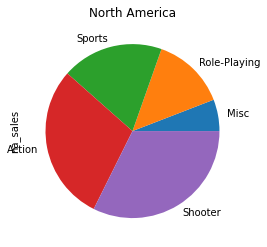

In [42]:
data_grouped = data_grouped.sort_values('na_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='na_sales', x='genre', legend=False)
ax.set_title('North America')
plt.show()

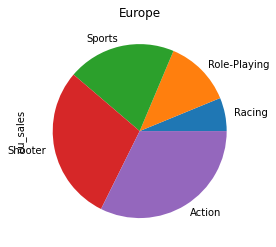

In [43]:
data_grouped = data_grouped.sort_values('eu_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='eu_sales', x='genre', legend=False)
ax.set_title('Europe')
plt.show()

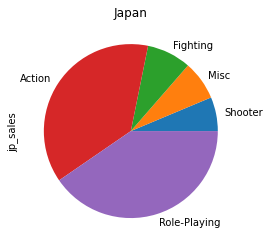

In [44]:
data_grouped = data_grouped.sort_values('jp_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='jp_sales', x='genre', legend=False)
ax.set_title('Japan')
plt.show()

#### Вывод

В Северной Америке лидируют: Shooter, Action, Sports

В Европе также лидируют: Shooter, Action, Sports

В Японии лидируют: Role-Playing, Action


В Европе и Америке одинаковые лидирующие жанры и примерно одинаковое соотношение. В Японии немного другая ситуация, другой менталитет, иное государство, совсем не похожее на Северную Америку и Европу, поэтому и лидирующие жанры другие. Возмонжо, есть запрет на какие-либо жанры.

### Рейтинг ESRB

In [45]:
#data_grouped = data[data['rating'] != 101]

data_grouped = data.groupby(['rating']).sum()

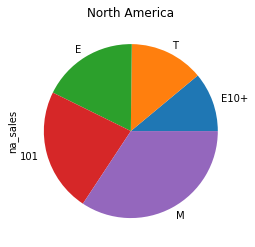

In [46]:
data_grouped = data_grouped.sort_values('na_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='na_sales', x='genre', legend=False)
ax.set_title('North America')
plt.show()

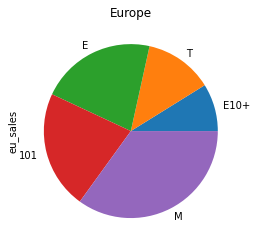

In [47]:
data_grouped = data_grouped.sort_values('eu_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='eu_sales', x='genre', legend=False)
ax.set_title('Europe')
plt.show()

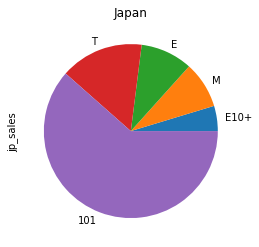

In [48]:
data_grouped = data_grouped.sort_values('jp_sales', ignore_index=False)

ax = data_grouped.tail().plot.pie(y='jp_sales', x='genre', legend=False)
ax.set_title('Japan')
plt.show()

#### Вывод

В Северной Америки преобладают игры с рейтингом: M, E

В Европе преобладают игры с рейтингом: M, E

В Японии возможно преобладают игры с рейтингом: T, E

В наших данных было достаточно много пропусков в столбце rating. Они составляют не больше четверти данных относительно Северной Америки, Европы, но пропусков в данном столбце относительно Японии больше половины, поэтому мы не можем делать какие-либо выводы по данному региону.

## Проверка гипотез

### Гипотеза первая

Проверим, правда ли, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различные.

Так как сравниваем две независимые генеральные совокупности, будем использовать критерий st_ttest_ind

In [49]:
data_pt = data[data['user_score'] != 101]

data_XOne = data_pt[data_pt['platform'] == 'XOne']
data_PC = data_pt[data_pt['platform'] == 'PC']

In [50]:
results = st.ttest_ind(
    data_XOne['user_score'],
    data_PC['user_score'],
    equal_var = False
) 

alpha = 0.05
print(results.pvalue)

if  results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


#### Вывод

На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований отвергнуть нулевую гипотезу в пользу альтернативы.

### Гипотеза вторая

Проверим правда ли, что cредние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: cредние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза: cредние пользовательские рейтинги жанров Action и Sports различные.

Так как сравниваем две независимые генеральные совокупности, будем использовать критерий st_ttest_ind

In [51]:
data_action = data_pt[data_pt['genre'] == 'Action']
data_sports = data_pt[data_pt['genre'] == 'Sports']

In [52]:
results = st.ttest_ind(
    data_action['user_score'],
    data_sports['user_score'],
    equal_var = False
) 

alpha = 0.05
print(results.pvalue)

if  results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.1825550382644557e-14
Отвергаем нулевую гипотезу


#### Вывод

На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативы.

То есть cредние пользовательские рейтинги жанров Action и Sports различные.

## Общий вывод

Выпуск компьютерных игр постпенно взрастал до 2008-2009 годов, затем начал снижаться.

За все время существования наиболее популярные платформы к 2016 году по продажам: PS3 X360 PS2.

Необходимо было составить прогноз на 2017 год, поэтому был взят актуальный период в три последних года с 2014 по 2016.

**Были проанализированы самые прибыльные жанры** - это Shooter, Sports и Platform. Причем, жанр Shooter прибыльней остальных в 2 и болле раз.

**Далее был проведен анализ влияния оценки кртиков и пользователей на продажи:** 

Оценка пользователей и критиков не влияет на продажи.
Но большая оценка критиков может говорить о больших продажах, маленькая - не может.

**Были проанализированы самые популярные платформы по регионам:**

В Северной Америке самые популярные платформы: PS4, XOne, X360, PS4 и XOne составляют по одной трети от всех продаж популярных платформ.

В Европе самые популярные платформы: PS4, XOne, PS3, PS4 составляет больше половины от всех продаж популярных платформ.

В Японии самые популярные платформы: 3DS, PS4, PSv, 3DS составляет около половины от всех продаж популярных платформ.

**Также проанализированы самые популярные жанры по регионам:**

В Северной Америке лидируют: Shooter, Action, Sports

В Европе также лидируют: Shooter, Action, Sports

В Японии лидируют: Role-Playing, Action

**Далее проанализировали рейтинг игр в каждом регионе:**

В Северной Америки преобладают игры с рейтингом: M, E

В Европе преобладают игры с рейтингом: M, E

В Японии возможно преобладают игры с рейтингом: T, E


**Проверили две гипотезы, в выводе получив, что:**
1) Средние пользовательские рейтинги платформ Xbox One и PC могут быть как одинаковыми и различными.<br>
2) Средние пользовательские рейтинги жанров Action и Sports различные.

### Совет заказчику

Можно выделить три жанра игр, к которым интернет-магазину стоит присмотреться - это Shooter, Sports и Platform. Это самые прибыльные жанры.<br>
При этом ставить в приоритет те игры, которые критики оценили более, чем в 60 баллов.

При планировании рекламных компаний следует учесть, что предпочтения пользователей в разных регионах различны, например:<br>

В Северной Америке более популярны такие платформы, как PS4 и XOne<br>
В Европе более популярна PS4<br>
И этих регионах популярные жанры: Shooter, Action, Sports.<br>

А в Японии популярная плафторма - это 3DS<br>
И поплурные жанры: Role-Playing и Action<br>